In [6]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt

In [7]:
print("GPU Available:", tf.test.is_gpu_available())
print("TensorFlow Version:", tf.__version__)
print("GPU Device Name:", tf.config.experimental.list_physical_devices('GPU'))

GPU Available: True
TensorFlow Version: 2.16.2
GPU Device Name: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-04-03 03:26:04.518516: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 03:26:04.518588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

print("Now using:", tf.config.list_physical_devices('GPU'))

Now using: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

In [10]:
# OCT images of 1024 x 1024 pixels with 1 channel
IMG_ROWS=224; IMG_COLS=224; IMG_CHANNELS=1
IMAGE_SIZE = [IMG_ROWS, IMG_COLS]

In [11]:
WHICH_MODEL = 'DenseNet121'

if WHICH_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1], and IMAGE_SIZE + [3] = [224, 224, 3]
    orig_model = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG16_oct_minipigs.h5'

elif WHICH_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19
    from keras.applications.vgg19 import preprocess_input

    # for RGB channel use [3], for black and white use one channel [1]
    orig_model = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'VGG19_oct_minipigs.h5'

elif WHICH_MODEL == 'ResNet50':
    from keras.applications.resnet50 import ResNet50
    from keras.applications.resnet50 import preprocess_input

    orig_model = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.001
    OCT_MODEL_NAME = 'ResNet50_oct_minipigs.h5'

elif WHICH_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3
    from keras.applications.inception_v3 import preprocess_input

    orig_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'InceptionV3_oct_minipigs.h5'

elif WHICH_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121
    from keras.applications.densenet import preprocess_input
    orig_model = DenseNet121(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
    LEARN_RATE = 0.0001
    OCT_MODEL_NAME = 'DenseNet121_oct_minipigs.h5'

2025-04-03 03:26:04.559809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 03:26:04.559836: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
BATCH_SIZE = 32

EPOCHS = 150

In [13]:
# path to TRAINING dataset of the OCT images
TRAIN_PATH = '../PigData_PP/training'

# path to VALIDATE dataset of the OCT images
VALID_PATH = '../PigData_PP/val'

# path to TESTING dataset of the OCT images
TEST_PATH = '../PigData_PP/test'

DATASET = 'Minipigs'

CLASS_MODE = 'categorical'   # binary, categorical

NUMBER_OF_CLASSES = 5


In [14]:

adam = Adam(learning_rate=LEARN_RATE)
#adam = Adam(learning_rate=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam', decay=LEARN_RATE/EPOCHS)

#sgd = SGD(learning_rate=LEARN_RATE)

OPTIMISATION = adam  # SGD

# no need to train the weights again
for layer in orig_model.layers[:-15]:
    layer.trainable = False

In [15]:
# to retrieve the number of classes
folders = glob(TRAIN_PATH + '/*')

In [16]:
# more layers could be added to the model
x = Flatten()(orig_model.output)
x = Dropout(0.3)(x)

prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=orig_model.input, outputs=prediction)

In [17]:
# view the structure of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ cast[0][0]        │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b

 Total params: 7,288,389 (27.80 MB)

 Trainable params: 579,013 (2.21 MB)

 Non-trainable params: 6,709,376 (25.59 MB)

In [18]:
# tell the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer=OPTIMISATION,
    metrics=['accuracy']
)

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [20]:
training_set = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 2590 images belonging to 5 classes.


In [21]:
valid_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=350, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.15, zoom_range=0.1,
    channel_shift_range=10., horizontal_flip=True, fill_mode='constant'
)

In [22]:
valid_set = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 740 images belonging to 5 classes.


In [23]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_set = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_ROWS, IMG_COLS),
    batch_size=BATCH_SIZE,
#    seed=42,
#    color_mode=COLOUR_MODE,
    class_mode=CLASS_MODE
)

Found 370 images belonging to 5 classes.


In [24]:
# fit the model
history = model.fit(
    training_set,
    validation_data=valid_set,
    epochs=EPOCHS,
    steps_per_epoch=len(training_set),
#    validation_split=0.1
    validation_steps=len(valid_set)
)

#time taken: 3 hours

/Users/owner/anaconda3/envs/tfmac/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150


2025-04-03 03:26:10.706715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


81/81 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.2923 - loss: 2.5783 - val_accuracy: 0.5419 - val_loss: 1.1394
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 76s 928ms/step - accuracy: 0.5648 - loss: 1.3042 - val_accuracy: 0.6459 - val_loss: 0.8850
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 81s 994ms/step - accuracy: 0.6195 - loss: 1.1213 - val_accuracy: 0.6905 - val_loss: 0.8311
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 80s 981ms/step - accuracy: 0.6585 - loss: 0.9894 - val_accuracy: 0.7189 - val_loss: 0.7989
Epoch 5/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 80s 981ms/step - accuracy: 0.6874 - loss: 0.8716 - val_accuracy: 0.7851 - val_loss: 0.6265
Epoch 6/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 948ms/step - accuracy: 0.7242 - loss: 0.7866 - val_accuracy: 0.7797 - val_loss: 0.5504
Epoch 7/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 77s 945ms/step - accuracy: 0.7372 - loss: 0.7289 - val_accuracy: 0.7784 - val_loss: 0.6001
Epoch 8/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 76s 938ms/step - accuracy: 0.7606 - loss: 0.7025 - val_accuracy: 0

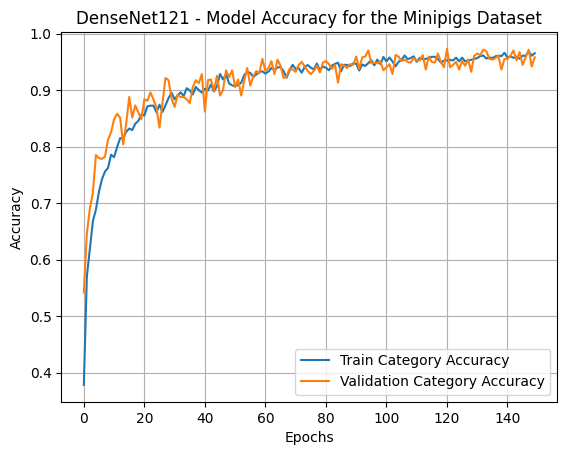

In [25]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
acc_title = "{} - Model Accuracy for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(acc_title)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Train Category Accuracy', 'Validation Category Accuracy'], loc='lower right')
plt.show()

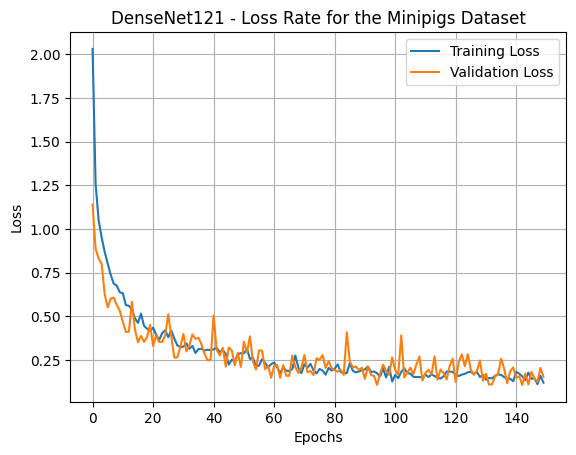

In [26]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
loss_title = "{} - Loss Rate for the {} Dataset".format(WHICH_MODEL, DATASET)
plt.title(loss_title)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid(True)
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [27]:
train_loss, train_acc = model.evaluate(training_set, steps=16)
valid_loss, valid_acc = model.evaluate(valid_set, steps=16)

print('\nLearn Rate =', LEARN_RATE, ', Epochs =', EPOCHS, ', Training Folder =', TRAIN_PATH)

print('Validation Folder =', VALID_PATH, ', Test Folder =', TEST_PATH)

print('\nTraining: %.3f, Validation: %.3f' % (train_acc, valid_acc))

print('\nThe processing of Convolutional Neural Networks with Transfer Learning for', WHICH_MODEL, 'succeed.\n')

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 723ms/step - accuracy: 0.9943 - loss: 0.0236
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 748ms/step - accuracy: 0.9423 - loss: 0.1913

Learn Rate = 0.0001 , Epochs = 150 , Training Folder = ../PigData_PP/training
Validation Folder = ../PigData_PP/val , Test Folder = ../PigData_PP/test

Training: 0.990, Validation: 0.941

The processing of Convolutional Neural Networks with Transfer Learning for DenseNet121 succeed.



In [28]:
results = model.evaluate(test_set, steps=16)
print("\nTest loss and accuracy are:", results)

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 714ms/step - accuracy: 0.9399 - loss: 0.2210

Test loss and accuracy are: [0.28423047065734863, 0.9324324131011963]


/Users/owner/anaconda3/envs/tfmac/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [29]:
model.save('model_with_dropout(_15_layers_&_30_do_&_150_epochs_trial_32).h5')

In [30]:
#!pip install scikit-learn
#!pip install seaborn

In [31]:
cnn_predictions = model.predict(test_set)
print('\nPredictions:\n')
print(cnn_predictions)

cnn_predictions_max = cnn_predictions.argmax(axis=1)
print('\nPredictions argmax(axis=1):\n')
print(cnn_predictions_max)

print(test_set.labels)

print('\nTesting execution ended.\n')


12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step 

Predictions:

[[0.000e+00 1.000e+00 3.576e-07 0.000e+00 0.000e+00]
 [0.000e+00 4.828e-06 0.000e+00 0.000e+00 1.000e+00]
 [4.206e-04 2.269e-04 9.995e-01 4.101e-05 0.000e+00]
 ...
 [4.108e-03 5.875e-02 9.370e-01 2.384e-07 0.000e+00]
 [0.000e+00 1.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [5.543e-06 1.000e+00 0.000e+00 0.000e+00 0.000e+00]]

Predictions argmax(axis=1):

[1 4 2 0 2 3 4 2 2 0 3 3 3 2 2 2 4 2 0 3 4 3 2 4 1 1 2 0 0 1 4 3 1 0 4 4 2
 2 3 0 3 3 4 0 2 1 4 2 3 3 2 3 0 4 2 1 3 2 1 1 0 0 2 4 0 4 1 2 1 4 3 3 3 2
 0 2 2 0 2 4 3 1 4 3 2 1 1 4 0 3 0 0 1 1 3 2 1 4 4 1 4 1 0 0 1 3 2 3 1 3 2
 1 2 0 1 1 3 0 4 3 1 1 4 4 2 4 4 3 4 2 3 3 2 2 0 4 3 3 3 4 4 2 0 4 0 2 1 1
 2 3 2 1 4 3 3 0 1 0 1 1 1 3 2 4 1 1 3 3 2 1 1 3 2 3 0 4 0 0 4 4 1 0 0 1 2
 4 3 1 0 1 4 2 0 2 1 2 2 4 4 2 3 4 2 1 4 0 1 0 2 0 3 2 0 2 1 1 0 1 0 1 1 3
 2 0 4 3 1 2 4 4 1 2 3 1 2 2 4 1 3 2 2 2 3 1 4 4 2 4 3 1 3 2 2 4 3 2 0 1 4
 1 0 3 4 0 0 3 4 0 1 0 2 3 2 3 2 4 0 0 2 4 3 0 0 3 2 1 1 0 1 2 2 3

In [32]:

import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

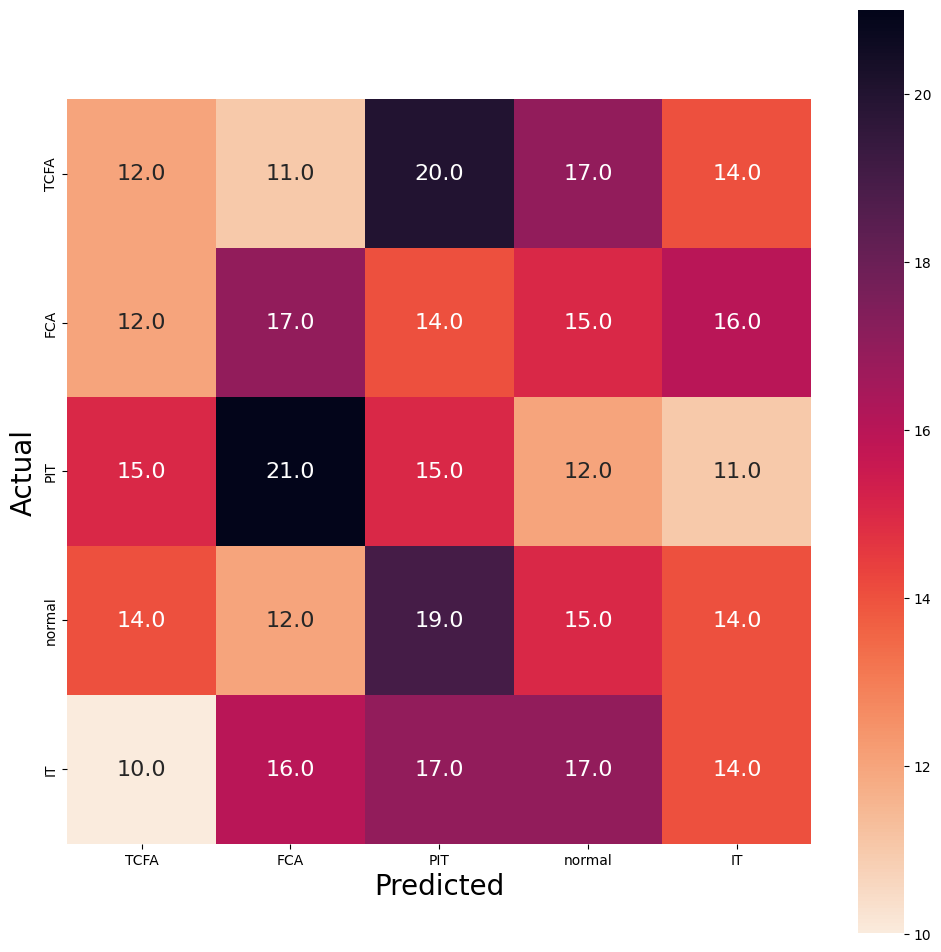

In [33]:


label = ['TCFA', 'FCA', 'PIT', 'normal', 'IT']
#Ypred = np.argmax(cnn_predictions, axis=1)
#Ytrue = np.argmax(test_set.labels, axis=0)

cm = confusion_matrix(test_set.labels, cnn_predictions_max)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()